In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
pwd

'/kaggle/working'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

subm_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [5]:
train_data.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [6]:
import seaborn as sns

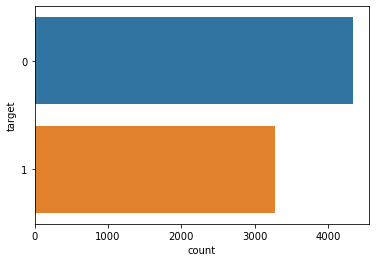

In [7]:
sns.countplot(y = train_data.target)

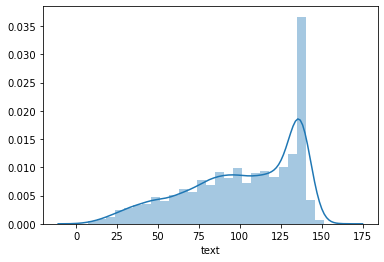

In [8]:
sns.distplot(train_data.text.str.len(), label='Average Text Length')

In [9]:
most_freq_words = pd.Series(" ".join(train_data['text']).split()).value_counts()

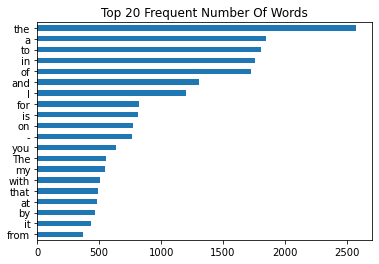

In [10]:
most_freq_words.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Number Of Words")

Lets look into Bi-Grams and what are those.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')

In [13]:
sparse_matrix = word_vectorizer.fit_transform(train_data["text"])
frequencies = sum(sparse_matrix).toarray()[0]
bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])



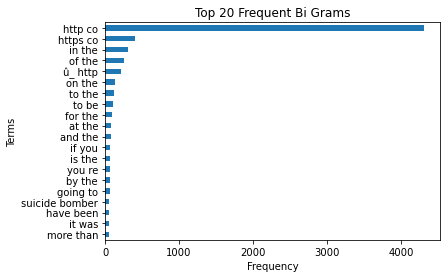

In [14]:
plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_bigrams = bi_grams_df["frequency"].sort_values(ascending = False).head(20)

top20_bigrams.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Bi Grams")

Looks like a lot of stopwords, punctuation and http links are present in the data. MUST REMOVE IT!!

**Text Cleaning**

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

In [16]:
# To lower case text
train_data['text'] = train_data.text.str.lower()

In [17]:
# remove stopwords

stop_words = stopwords.words('english')

In [18]:
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [19]:
tokenized_doc = train_data['text'].apply(lambda x: x.split())

In [20]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [21]:
train_data['clean_text'] = tokenized_doc.astype(str).str.replace('\[|\]|\'', '')
train_data['clean_text'] = train_data.clean_text.str.replace(",",'')

In [22]:
train_data['clean_text'] = train_data.clean_text.str.replace(r'[^\w\s]', '')

In [23]:
train_data.head(2)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada


In [24]:
def top_n_words(text, n):
    
    most_freq_words = pd.Series(" ".join(text).split()).value_counts()
    return most_freq_words.head(n).sort_values(ascending = True).plot(kind="barh",title = "Top {n} Frequent Number Of Words".format(n = n))

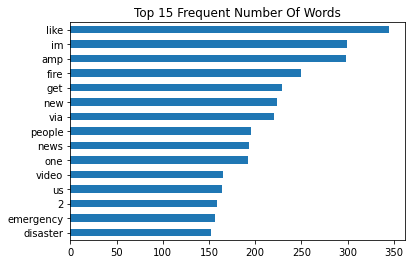

In [25]:
top_n_words(train_data.clean_text, 15)

In [26]:
# Remove numbers from the text
train_data.clean_text.str.replace('\d+', '')

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610             m  utckm volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: clean_text, Length: 7613, dtype: object

In [27]:
# Remove URLs
train_data['clean_text'] = train_data.clean_text.apply(lambda x: re.sub(r"http\S+", "", str(x)))

# Remove numbers
train_data['clean_text'] = train_data.clean_text.str.replace('\d+', '')
# re.sub(r'https?:\/\/.*[\r\n]*', '', str(train_data.clean_text))

In [28]:
train_data

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,aria_ahrary thetawniest control wild fires cal...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m utckm volcano hawaii
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


In [29]:
# train test split
target = train_data['target']
    
x_train, x_test, y_train, y_test = train_test_split(train_data['clean_text'], target, test_size=0.30, random_state=100)

In [30]:
# Feature extraction

vectorizer = CountVectorizer(max_df = 0.7, max_features=1000)

In [31]:
train_df = vectorizer.fit_transform(x_train.values.astype('U'))
    
test_df = vectorizer.transform(x_test.values.astype('U'))

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
model = LogisticRegression()

In [34]:
model.fit(train_df, y_train)

LogisticRegression()

In [35]:
model.predict(test_df)

array([1, 0, 1, ..., 0, 0, 1])

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
# prediction on test samples

preds1 = pd.DataFrame(model.predict_proba(test_df), 
                     # index=X_test_post_encoding.index, 
                     columns= ['prob_0', 'prob_1'])
# test_df = pd.concat([X_test_post_encoding, y_test, preds], axis = 1)

In [38]:
# precision recall curve

lr_precision1, lr_recall1, _1 = precision_recall_curve(y_true = y_test, probas_pred = preds1.prob_1)

Text(0.5, 1.0, 'Precision-Recall Curve - LogisticRegression')

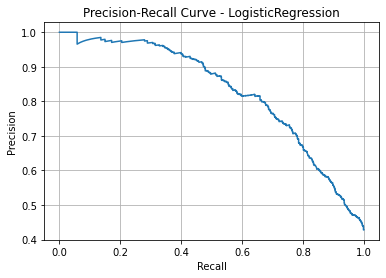

In [39]:
# Precision recall curve

plt.plot(lr_recall1, lr_precision1)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LogisticRegression')